# CMA-ES on Feedforward Pendulum Agent
## Adapted from [Rob's Blogpost](https://roberttlange.github.io/posts/2021/02/cma-es-jax/)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
from jax import jit, vmap, lax
import functools, time
import matplotlib.pyplot as plt

from es_helpers import (init_cma_es,              # Initializes the parameters of the strategy
                        eigen_decomposition,      # Performs an eigendecomposition of a PSD matrix
                        check_termination,        # Checks whether the search has converged/diverged
                        init_logger,              # Initializes a logging dict for the search
                        update_logger,            # Updates the logging dict with newest results/stats
                        plot_fitness,             # Visualize fitness and stepsize log
                        plot_sigma)                

# Import `gymnax` and make `Pendulum-v0` environment transition/reset

In [2]:
import gymnax
rng, env = gymnax.make("Pendulum-v0")
obs, state = env.reset(rng)
action = env.action_space.sample(rng)
obs, state, reward, terminal, info = env.step(rng, state, action)

# Setup Ask and Tell API for CMA-ES

In [3]:
def ask(rng, params, memory):
    """ Propose parameters to evaluate next. """
    C, B, D = eigen_decomposition(memory["C"], memory["B"], memory["D"])
    x = sample(rng, memory, B, D, params["n_dim"], params["pop_size"])
    memory["C"], memory["B"], memory["D"] = C, B, D
    return x, memory

@functools.partial(jit, static_argnums=(4, 5))
def sample(rng, memory, B, D, n_dim, pop_size):
    """ Jittable Multivariate Gaussian Sample Helper. """
    z = jax.random.normal(rng, (n_dim, pop_size)) # ~ N(0, I)
    y = B.dot(jnp.diag(D)).dot(z)                 # ~ N(0, C)
    y = jnp.swapaxes(y, 1, 0)
    x = memory["mean"] + memory["sigma"] * y      # ~ N(m, σ^2 C)
    return x

@jit
def tell(x, fitness, params, memory):
    """ Update the surrogate ES model. """
    # Update/increase the generation counter
    memory["generation"] = memory["generation"] + 1

    # Sort new results, extract parents, store best performer
    concat_p_f = jnp.hstack([jnp.expand_dims(fitness, 1), x])
    sorted_solutions = concat_p_f[concat_p_f[:, 0].argsort()]

    # Update mean, isotropic path, stepsize, anisotropic path, cov.
    mean, y_k, y_w = update_mean(sorted_solutions, params, memory)
    memory["mean"] = mean

    p_sigma, C_2, C, B, D = update_p_sigma(y_w, params, memory)
    memory["p_sigma"], memory["C"], memory["B"], memory["D"] = p_sigma, C, B, D

    sigma, norm_p_sigma = update_sigma(params, memory)
    memory["sigma"] = sigma

    p_c, ind_sigma = update_p_c(y_w, norm_p_sigma, params, memory)
    memory["p_c"] = p_c

    C = update_covariance(y_k, ind_sigma, C_2, params, memory)
    memory["C"] = C
    return memory

In [4]:
def update_mean(sorted_solutions, params, memory):
    """ Update mean of strategy. """
    x_k = sorted_solutions[:, 1:]       # ~ N(m, σ^2 C)
    y_k_temp = (x_k - memory["mean"])   # ~ N(0, σ^2 C)
    y_w_temp = jnp.sum(y_k_temp.T * params["weights_truncated"], axis=1)
    mean = memory["mean"] + params["c_m"] * y_w_temp
    # Comple z-scoring for later updates
    y_k = y_k_temp / memory["sigma"]
    y_w = y_w_temp / memory["sigma"]
    return mean, y_k, y_w


def update_p_sigma(y_w, params, memory):
    """ Update evolution path for covariance matrix. """
    C, B, D = eigen_decomposition(memory["C"], memory["B"], memory["D"])
    C_2 = B.dot(jnp.diag(1 / D)).dot(B.T)  # C^(-1/2) = B D^(-1) B^T
    p_sigma_new = (1 - params["c_sigma"]) * memory["p_sigma"] + jnp.sqrt(
        (1 - (1 - params["c_sigma"])**2) *
        params["mu_eff"]) * C_2.dot(y_w)
    _B, _D = None, None
    return p_sigma_new, C_2, C, _B, _D


def update_sigma(params, memory):
    """ Update stepsize sigma. """
    norm_p_sigma = jnp.linalg.norm(memory["p_sigma"])
    sigma = (memory["sigma"] * jnp.exp((params["c_sigma"] / params["d_sigma"])
                                      * (norm_p_sigma / params["chi_d"] - 1)))
    return sigma, norm_p_sigma


def update_p_c(y_w, norm_p_sigma, params, memory):
    """ Update evolution path for sigma/stepsize. """
    ind_sigma_cond_left = norm_p_sigma / jnp.sqrt(
        1 - (1 - params["c_sigma"]) ** (2 * (memory["generation"] + 1)))
    ind_sigma_cond_right = (1.4 + 2 / (memory["mean"].shape[0] + 1)) * params["chi_d"]
    ind_sigma = 1.0 * (ind_sigma_cond_left < ind_sigma_cond_right)
    p_c = (1 - params["c_c"]) * memory["p_c"] + ind_sigma * jnp.sqrt((1 -
          (1 - params["c_c"])**2) * params["mu_eff"]) * y_w
    return p_c, ind_sigma


def update_covariance(y_k, ind_sigma, C_2, params, memory):
    """ Update cov. matrix estimator using rank 1 + μ updates. """
    w_io = params["weights"] * jnp.where(params["weights"] >= 0, 1,
                                        memory["mean"].shape[0]/
            (jnp.linalg.norm(C_2.dot(y_k.T), axis=0) ** 2 + 1e-20))
    c_s = (1 - ind_sigma) * params["c_1"] * params["c_c"] * (2 - params["c_c"])
    rank_one = jnp.outer(memory["p_c"], memory["p_c"])
    rank_mu = jnp.sum(
        jnp.array([w * jnp.outer(y, y) for w, y in zip(w_io, y_k)]), axis=0)
    C = ((1 - params["c_1"] - params["c_mu"] * jnp.sum(params["weights"]) + c_s ) * memory["C"]
         + params["c_1"] * rank_one + params["c_mu"] * rank_mu)
    return C


# Define Agent's Policy and Rollout Helpers

In [5]:
def ffw_policy(params, obs):
    """ Compute forward pass and return action from deterministic policy """
    def relu_layer(W, b, x):
        """ Simple ReLu layer for single sample """
        return jnp.maximum(0, (jnp.dot(W, x) + b))
    # Simple single hidden layer MLP: Obs -> Hidden -> Action
    activations = relu_layer(params["W1"], params["b1"], obs)
    mean_policy = jnp.dot(params["W2"], activations) + params["b2"]
    return mean_policy

def policy_pendulum_step(state_input, tmp):
    """ lax.scan compatible step transition in jax env. """
    obs, state, policy_params, rng = state_input
    rng, key_step = jax.random.split(rng)
    action = ffw_policy(policy_params, obs)
    next_o, next_s, reward, done, _ = env.step(key_step, state, action)
    carry, y = [next_o.squeeze(), next_s,
                policy_params, rng], [reward]
    return carry, y

def pendulum_rollout(rng, policy_params, num_steps):
    """ Rollout a pendulum episode with lax.scan. """
    rng, key_reset = jax.random.split(rng)
    obs, state = env.reset(key_reset)
    _, scan_out = jax.lax.scan(policy_pendulum_step,
                               [obs, state, policy_params, rng],
                               [jnp.zeros(num_steps)])
    # Return the sum of rewards accumulated by agent in episode rollout
    return jnp.sum(jnp.array(scan_out))


# vmap over different MC fitness evaluations for single pop. member
batch_rollout = jit(vmap(pendulum_rollout, in_axes=(0, None, None),
                         out_axes=0), static_argnums=2)

# vmap over different members in the population
v_dict = {"W1": 0, "b1": 0, "W2": 0, "b2": 0}
generation_rollout = jit(vmap(batch_rollout,
                              in_axes=(None, v_dict, None),
                              out_axes=0), static_argnums=2)

In [6]:
def flat_to_network(flat_params, layer_sizes):
    """ Reshape flat parameter vector to feedforward network param dict. """
    pop_size = flat_params.shape[0]
    W1_stop = layer_sizes[0]*layer_sizes[1]
    b1_stop = W1_stop + layer_sizes[1]
    W2_stop = b1_stop + (layer_sizes[1]*layer_sizes[2])
    b2_stop = W2_stop + layer_sizes[2]
    # Reshape params into weight/bias shapes
    params = {"W1": flat_params[:, :W1_stop].reshape(pop_size,
                                                     layer_sizes[1],
                                                     layer_sizes[0]),
              "b1": flat_params[:, W1_stop:b1_stop],
              "W2": flat_params[:, b1_stop:W2_stop].reshape(pop_size,
                                                            layer_sizes[2],
                                                            layer_sizes[1]),
              "b2": flat_params[:, W2_stop:b2_stop]}
    return params

# Run the CMA Evolutionary Strategy

In [8]:
# Setup the ES hyperparameters
num_generations = 200
num_evals_per_gen = 20
num_env_steps = 200
pop_size, parent_size = 100, 50

# Setup the random number gen., init ES and the logger
rng = jax.random.PRNGKey(0)
net_size = [3, 48, 1]
num_params = 3*48 + 48 + 48*1 + 1
mean_init, sigma_init = jnp.zeros(num_params), 1
params, memory = init_cma_es(mean_init, sigma_init, pop_size, parent_size)
top_k = 5
evo_logger = init_logger(top_k, num_params)


# Loop over different generations in evolutionary strategy
start_t = time.time()
for g in range(num_generations):
    rng, rng_ask, rng_eval = jax.random.split(rng, 3)
    # Ask for set of proposal param candidates and reshape
    x, memory = ask(rng_ask, params, memory)
    generation_params = flat_to_network(x, net_size)
    rollout_keys = jax.random.split(rng_eval, num_evals_per_gen)

    # Evaluate generation population on pendulum task - min cost!
    population_returns = generation_rollout(rollout_keys, generation_params,
                                            num_env_steps)
    values = - population_returns.mean(axis=1)

    # Tell the results and update the strategy + logger
    memory = tell(x, values, params, memory)
    evo_logger = update_logger(evo_logger, x, values, memory, top_k)
    if (g + 1) % 15 == 0:
        print("# Generations: {} | Fitness: {:.2f} | Cum. Time: {:.2f}".format(g+1, evo_logger["top_values"][0],
                                                                               time.time()-start_t))
        if check_termination(values, params, memory):
            break

# Generations: 15 | Fitness: 715.71 | Cum. Time: 6.06
# Generations: 30 | Fitness: 485.69 | Cum. Time: 7.68
# Generations: 45 | Fitness: 485.69 | Cum. Time: 8.92
# Generations: 60 | Fitness: 485.69 | Cum. Time: 10.14
# Generations: 75 | Fitness: 360.11 | Cum. Time: 11.42
# Generations: 90 | Fitness: 218.72 | Cum. Time: 12.71
# Generations: 105 | Fitness: 191.75 | Cum. Time: 13.99
# Generations: 120 | Fitness: 157.19 | Cum. Time: 15.28
# Generations: 135 | Fitness: 129.72 | Cum. Time: 16.62
# Generations: 150 | Fitness: 129.72 | Cum. Time: 17.94
# Generations: 165 | Fitness: 122.95 | Cum. Time: 19.24
# Generations: 180 | Fitness: 122.95 | Cum. Time: 20.54
# Generations: 195 | Fitness: 122.95 | Cum. Time: 21.80


(<Figure size 1080x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffd5e624208>)

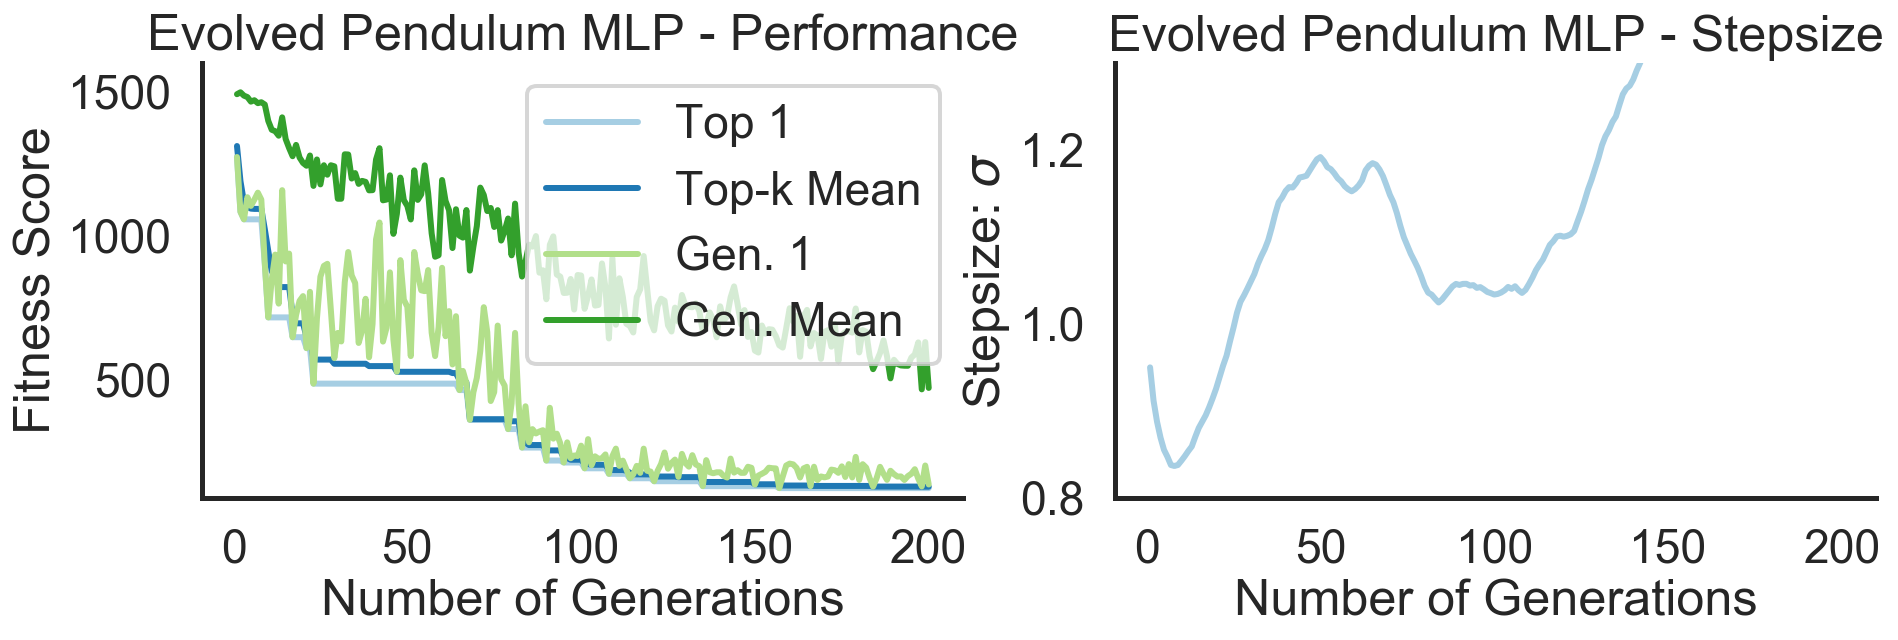

In [9]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
plot_fitness(evo_logger, title="Evolved Pendulum MLP - Performance", ylims=(90, 1600), fig=fig, ax=axs[0])
plot_sigma(evo_logger, title="Evolved Pendulum MLP - Stepsize", ylims=(0.8, 1.3), fig=fig, ax=axs[1])